## Autoencoders

In [1]:
from utils import *
import sys

In [2]:
import numpy.random as rnd

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [17]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

## Performing PCA with an Undercomplete Linear Autoencoder
If the autoencoder uses only linear activations and the cost function is the Mean Squared Error (MSE), then it can be shown that it ends up performing Principle Component Analysis.

To perform simple PCA, we set `activation=None` and the cost function is the MSE.

## Stacked Autoencoders

In [4]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                        activation=tf.nn.elu,
                        kernel_initializer = he_init,
                        kernel_regularizer = l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() 

In [8]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print('\r{}%'.format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print('\r{}'.format(epoch), 'Train MSE:', loss_train)
        saver.save(sess, '/tmp/my_model_all_layers.ckpt')

0 %Train MSE: 0.021055132
1 Train MSE: 0.01139003
2 Train MSE: 0.010218927
3 Train MSE: 0.009899378
4 Train MSE: 0.010372169


In [37]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        print(X_test[digit_index].shape)
        plot_image(X_test[digit_index].flatten())
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from /tmp/my_model_all_layers.ckpt
(784,)
(784,)


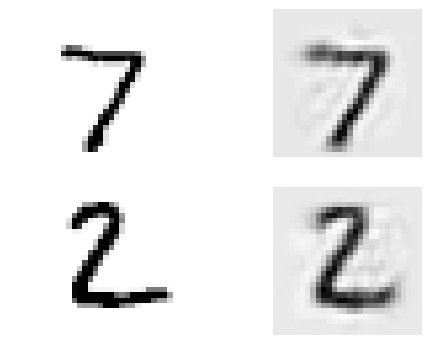

In [18]:
show_reconstructed_digits(X, outputs, '/tmp/my_model_all_layers.ckpt')

## Tying weights
It is common to tie the weights of the encoder and decoder (`weights_decoder = tf.transpose(weights_encoder)`). This halves the number of weights in the model, speeding up training and limiting the risk of overfitting. Specifically, if the autoencoder has a total of $N$ layers, (not counting the input layer) and $\mathbf{W}_L$ represents the connection weights of the $L^{\mathrm{th}}$ layer, then the decoder layer weights can be defined simply as 
$\mathbf{W}_{N-L+1} = \mathbf{W}_L^T$, with $L=1,2,\cdot,\frac{N}{2}$.


Unfortunately this makes it impossible to use the `tf.layers.dense()` function, so we need to build the Autoencoder manually:

In [19]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [20]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name='weights1')
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name='weights2')
weights3 = tf.transpose(weights2, name='weights3') # tied weights
weights4 = tf.transpose(weights1, name='weights4') # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name='biases1')
biases2 = tf.Variable(tf.zeros(n_hidden2), name='biases2')
biases3 = tf.Variable(tf.zeros(n_hidden3), name='biases3')
biases4 = tf.Variable(tf.zeros(n_outputs), name='biases4')

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [21]:
saver = tf.train.Saver()

In [23]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print('\r{}%'.format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print('\r{}'.format(epoch), 'Train MSE:', loss_train)
        saver.save(sess, '/tmp/my_model_tying_weights.ckpt')    

09% Train MSE: 0.015066946
1 Train MSE: 0.016488746
2 Train MSE: 0.017375937
3 Train MSE: 0.016878333
4 Train MSE: 0.015587721


INFO:tensorflow:Restoring parameters from /tmp/my_model_tying_weights.ckpt
(784,)
(784,)


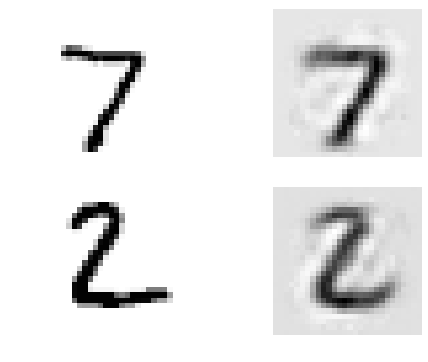

In [24]:
show_reconstructed_digits(X, outputs, '/tmp/my_model_tying_weights.ckpt')

## Training one Autoencoder at a time in multiple graphs

There are many ways to train one autoencoder at a time. The first approach is to train each autoencoder using a different graph, then we create the stacked autoencoder by simply initializing it with the weights and biases copied from these Autoencoders.

In [35]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size, learning_rate=0.01, l2_reg=0.0005, seed=42,
                     hidden_activation=tf.nn.elu, output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)
        
        n_inputs = X_train.shape[1]
        
        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))
        
        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name='hidden')
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name='outputs')
        
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
        
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)
        
        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)
        
        init = tf.global_variables_initializer()
        
    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print('\r{}%'.format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print('\r{}'.format(epoch), 'Train MSE', loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

Let's train two Autoencoders. The first one is trained on the training data, and the second is trained on the previous Autoencoder's hidden layer output:

In [36]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150, output_activation=None)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

0 Train MSE 0.01851794
1 Train MSE 0.01868272
2 Train MSE 0.018467719
3 Train MSE 0.019231753
0 %Train MSE 0.004236086
1 Train MSE 0.004832612
2 Train MSE 0.0046686903
3 Train MSE 0.0044038594


Finally, we can create a Stacked Autoencoder by simply reusing the weights and biases from the Autoencoder we just trained:

In [37]:
reset_graph()

n_inputs = 28 * 28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

(784,)
(784,)


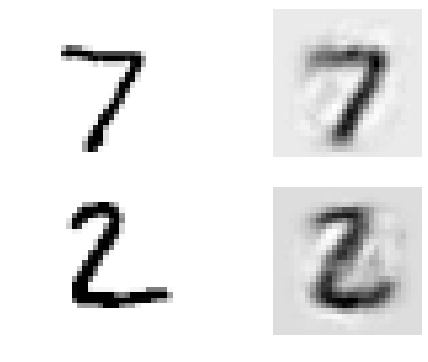

In [38]:
show_reconstructed_digits(X, outputs)

In [39]:
show_graph(tf.get_default_graph())

## Training one autoencoder at a time in a single graph
Another approach is to use a single graph. To do this, we create the graph for the full Stacked Autoencoder, but then we also add operations to train each Autoencoder independently: phase 1 trains the bottom and top layer (i.e. the first Autoencoder) and phase 2 trains the two middle layers (the second autoencoder)

In [21]:
reset_graph()
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [22]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # freeze hidden1

In [23]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [24]:
show_graph(tf.get_default_graph())

In [25]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "/tmp/my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.007951792
1 Train MSE: 0.0074930023
2 Train MSE: 0.007342081
3 Train MSE: 0.007669738
Training phase #2
0 Train MSE: 0.09044541
1 Train MSE: 0.0049939854
2 Train MSE: 0.0024819106
3 Train MSE: 0.0020974644
Test MSE: 0.00971027


### Cache the frozen layer outputs

In [26]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print('Training phase #{}'.format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print('\r{}%'.format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print('\r{}'.format(epoch), 'Train MSE:', loss_train)
            saver.save(sess, '/tmp/my_model_cache_frozen.ckpt')
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print('Test MSE:', loss_test)

Training phase #1
0 Train MSE: 0.0073977704
1 Train MSE: 0.007320049
2 Train MSE: 0.007678257
3 Train MSE: 0.007956529
Training phase #2
0 Train MSE: 0.24747728
1 Train MSE: 0.0055854
2 Train MSE: 0.002726209
3 Train MSE: 0.0020838275
Test MSE: 0.009685106


## Visualizing the Reconstructions

INFO:tensorflow:Restoring parameters from /tmp/my_model_one_at_a_time.ckpt


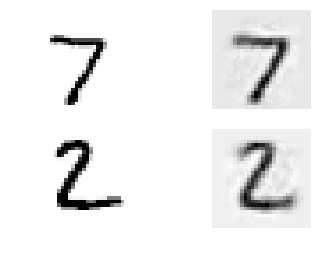

In [27]:
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, '/tmp/my_model_one_at_a_time.ckpt')
    outputs_val = outputs.eval(feed_dict={X: X_test})
    
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap='Greys', interpolation='nearest')
    plt.axis('off')
    
for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

### Visualizing the extracted features

INFO:tensorflow:Restoring parameters from /tmp/my_model_one_at_a_time.ckpt
Saving figure extracted_features_plot


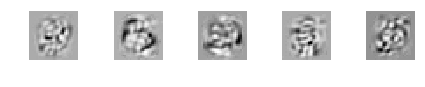

In [28]:
with tf.Session() as sess:
    saver.restore(sess, '/tmp/my_model_one_at_a_time.ckpt')
    weights1_val = weights1.eval()
    
for i in range(5):
    plt.subplot(1, 5, i+1)
    plot_image(weights1_val.T[i])
    
save_fig('extracted_features_plot')
plt.show()

## Unsupervised pretraining
Create a small neural network for MNIST classification.

In [29]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name='weights1')
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name='weights2')
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name='weights3')

biases1 = tf.Variable(tf.zeros(n_hidden1), name='biases1')
biases2 = tf.Variable(tf.zeros(n_hidden2), name='biases2')
biases3 = tf.Variable(tf.zeros(n_outputs), name='biases3')

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

In [30]:
show_graph(tf.get_default_graph())

Regular training: without pretraining

In [8]:
n_epochs = 4
batch_size = 150
n_labelled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labelled_instances // batch_size
        for iteration in range(n_batches):
            print('\r{}%'.format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labelled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print('\r{}'.format(epoch), 'Train accuracy:', accuracy_val, end=" ")
        saver.save(sess, '/tmp/my_model_supervised.ckpt')
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print('Test accuracy:', accuracy_val)

0 Train accuracy: 0.94666666 Test accuracy: 0.9243
1 Train accuracy: 0.97333336 Test accuracy: 0.9429
2 Train accuracy: 0.98 Test accuracy: 0.9405
3 Train accuracy: 0.98 Test accuracy: 0.9513


Now reusing the first two layers of the autoencoder we pretrained

In [31]:

n_epochs=4
batch_size = 150
n_labelled_instances = 20000

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, '/tmp/my_model_cache_frozen.ckpt')
    for epoch in range(n_epochs):
        n_batches = n_labelled_instances // batch_size
        for iteration in range(n_batches):
            print('\r{}%'.format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labelled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y:y_batch})
        print('\r{}'.format(epoch), 'Train accuracy:', accuracy_val, end='\t')
        saver.save(sess, '/tmp/my_model_supervised_pretrained.ckpt')
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print('Test accuracy:', accuracy_val)

INFO:tensorflow:Restoring parameters from /tmp/my_model_cache_frozen.ckpt
0 Train accuracy: 0.94666666	Test accuracy: 0.9104
1 Train accuracy: 0.98	Test accuracy: 0.947
2 Train accuracy: 0.97333336	Test accuracy: 0.9404
3 %Train accuracy: 0.96	Test accuracy: 0.9334


## Denoising autoencoders

Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise-free inputs. This prevents the autoencoder from trivially copyng its inputs to its outputs, so it ends up having to find patterns in the data.

## Spare Autoencoder

In [32]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # sparse codings
n_outputs = n_inputs

In [33]:
def kl_divergence(p, q):
    # Kullback Leibler divergence
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

In [34]:
learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])            # not shown in the book

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) # not shown
outputs = tf.layers.dense(hidden1, n_outputs)                     # not shown

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [35]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [36]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, 
                                                                         sparsity_loss, loss], 
                                                                        feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:",
              sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 Train MSE: 0.1469414 	Sparsity loss: 0.35479364 	Total loss: 0.21790013
1 Train MSE: 0.06008764 	Sparsity loss: 0.024903126 	Total loss: 0.06506827
2 Train MSE: 0.052481107 	Sparsity loss: 0.011986928 	Total loss: 0.054878492
3 Train MSE: 0.04845537 	Sparsity loss: 0.012040335 	Total loss: 0.050863437
4 Train MSE: 0.045498226 	Sparsity loss: 0.010756419 	Total loss: 0.04764951
5 Train MSE: 0.04105609 	Sparsity loss: 0.07270542 	Total loss: 0.05559717
6 Train MSE: 0.039006904 	Sparsity loss: 0.01730012 	Total loss: 0.042466927
7 Train MSE: 0.037342742 	Sparsity loss: 0.08844688 	Total loss: 0.05503212
8 Train MSE: 0.03321684 	Sparsity loss: 0.16394347 	Total loss: 0.066005535
9 Train MSE: 0.03144418 	Sparsity loss: 0.048411056 	Total loss: 0.041126393
10 Train MSE: 0.026606461 	Sparsity loss: 0.41934037 	Total loss: 0.11047454
11 Train MSE: 0.025663676 	Sparsity loss: 0.029579107 	Total loss: 0.0315795
12 Train MSE: 0.025997447 	Sparsity loss: 0.4057213 	Total loss: 0.10714171
13 Trai

INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt
(784,)
(784,)


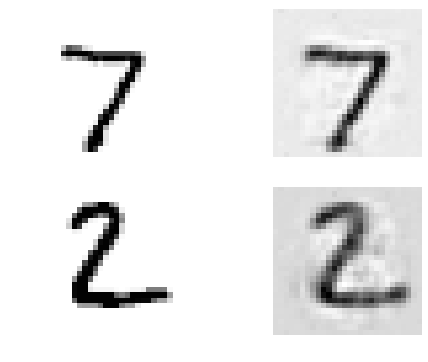

In [39]:
show_reconstructed_digits(X, outputs, './my_model_sparse.ckpt')